# Diffusion models

In [1]:
%load_ext autoreload
%autoreload 2

### - Required imports

In [2]:
import torch
import sys

from pathlib import Path
from matplotlib import pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from PIL import Image

project_root = Path().absolute().parent
sys.path.append(str(project_root))
project_root

PosixPath('/home/aorellan/DiffusionArcade')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n\n")

if device.type == "cuda":
    !nvidia-smi

Using device: cuda


Sun May 18 15:29:20 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:86:00.0 Off |                  Off |
| N/A   36C    P0              23W / 250W |      4MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----

In [4]:
from src.utils import login_huggingface, load_config, show_images, make_grid

login_huggingface()

### - Dataset

In [5]:
dataset = load_dataset("DiffusionArcade/Pong", split="train")

Resolving data files:   0%|          | 0/27239 [00:00<?, ?it/s]

In [6]:
dataset

Dataset({
    features: ['image', 'label', 'action', 'episode', 'step'],
    num_rows: 27235
})

In [7]:
split_datasets = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets["train"]
val_dataset   = split_datasets["test"]

### Visualizing dataset

In [8]:
image_size = 128
batch_size = 64

preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),   # Resize to square
    transforms.Grayscale(num_output_channels=1),   # → single‐channel “L” image
    transforms.ToTensor(),                         # → tensor in [0,1], shape = [1,H,W]
    transforms.Normalize([0.5], [0.5]),            # → tensor in [−1,1]
])


def transform(examples):
    imgs = [preprocess(img) for img in examples["image"]]
    return {"image": imgs}

train_dataset.set_transform(transform)
val_dataset.set_transform(transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

X shape: torch.Size([8, 1, 128, 128])
Batch of images in training dataset:


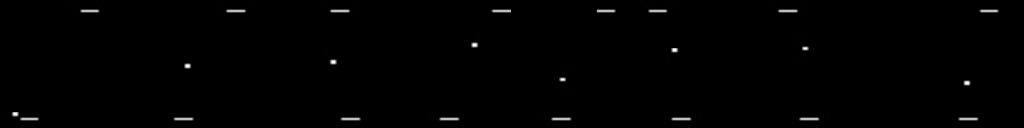

In [9]:
train_batch_images = next(iter(train_dataloader))["image"].to(device)[:8]
print("X shape:", train_batch_images.shape)

print('Batch of images in training dataset:')
show_images(train_batch_images).resize((8 * image_size, image_size), resample=Image.NEAREST)

X shape: torch.Size([8, 1, 128, 128])
Batch of images in validation dataset:


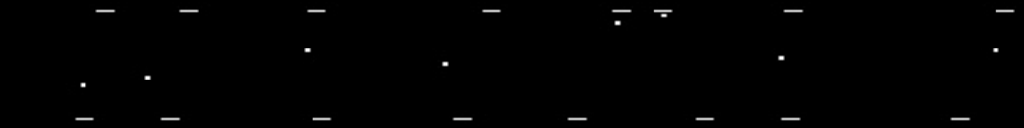

In [10]:
val_batch_images = next(iter(val_dataloader))["image"].to(device)[:8]
print("X shape:", val_batch_images.shape)

print('Batch of images in validation dataset:')
show_images(val_batch_images).resize((8 * image_size, image_size), resample=Image.NEAREST)

## - Forward diffusion process

In [11]:
from diffusers import DDIMScheduler

timesteps = 1000

schedulers = {
    "cosine": DDIMScheduler(
        num_train_timesteps=timesteps,
        beta_schedule="squaredcos_cap_v2"
    ),
    "linear": DDIMScheduler(
        num_train_timesteps=timesteps,
        beta_schedule="linear"
    ),
}

The forward diffusion process progressively adds noise to the original image $\mathbf{x}_0$ as timestep $t$ increases.

The process is defined by the re-parameterization formula:

$$
q(\mathbf{x}_t \mid \mathbf{x}_0)
    = \mathcal{N}\!\bigl(
        \mathbf{x}_t;\,
        \sqrt{\bar{\alpha}_t}\,\mathbf{x}_0,\,
        (1 - \bar{\alpha}_t)\,\mathbf{I}
      \bigr)
$$

where:

* $\mathbf{x}_t$ — noisy image at timestep $t$  
* $\sqrt{\bar{\alpha}_t}$ — scales down the original image  
* $1-\bar{\alpha}_t$ — variance of the added Gaussian noise

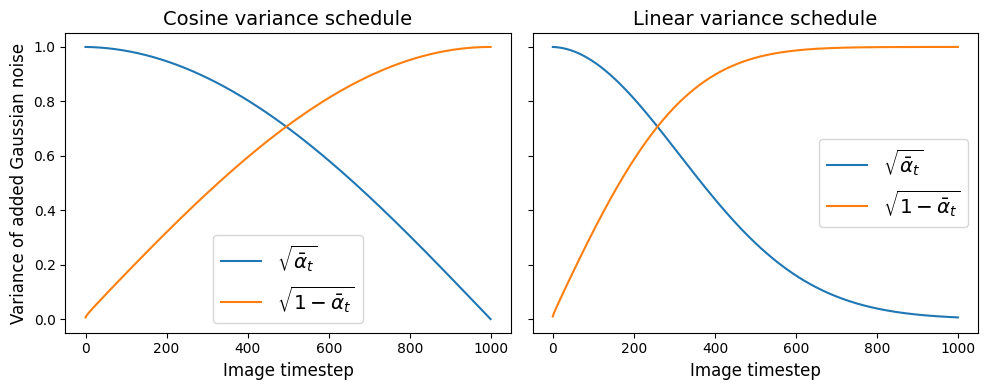

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for ax, (name, sched) in zip(axes, schedulers.items()):
    alphas_cumprod = sched.alphas_cumprod.cpu()
    
    ax.plot(
        alphas_cumprod ** 0.5,
        label=r"$\sqrt{\bar{\alpha}_t}$"
    )
    ax.plot(
        (1 - alphas_cumprod) ** 0.5,
        label=r"$\sqrt{1 - \bar{\alpha}_t}$"
    )
    ax.set_title(f"{name.capitalize()} variance schedule", fontsize=14)
    ax.set_xlabel("Image timestep", fontsize=12)
    ax.legend(fontsize="x-large")
    
axes[0].set_ylabel("Variance of added Gaussian noise", fontsize=12)

plt.tight_layout()
plt.show()

The more time steps, the more noise is added to the original image $\mathbf{x}_0$

In [13]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
timesteps

tensor([  0, 142, 285, 428, 570, 713, 856, 999], device='cuda:0')

The following images demonstrate the progressive addition of noise to the original image $\mathbf{x}_0$ across different timesteps. The sequence shows a gradual transition from minimal noise in the initial images to almost complete noise in the final image.

Noisy X shape torch.Size([8, 1, 128, 128])


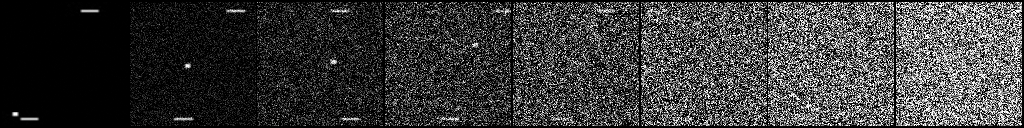

In [14]:
noise = torch.randn_like(train_batch_images) # same shape as xb: [Batch size, Channels, Height, Width]

noisy_train_batch_images = schedulers["cosine"].add_noise(train_batch_images, noise, timesteps)
print("Noisy X shape", train_batch_images.shape)
show_images(noisy_train_batch_images).resize((8 * image_size, image_size), resample=Image.NEAREST)

## - Diffusion model to generates Pong images

#### Training loop

In [12]:
from src.diffusion.model import DiffusionModel

config = load_config("../config.yaml")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_size=config['training_images']['image_size']
in_channels=config['training_images']['in_channels']
out_channels=config['training_images']['out_channels']
timesteps = config['training_images']['timesteps']
beta_schedule=config['training_images']['beta_schedule']

model = DiffusionModel(
    image_size=image_size,
    in_channels=in_channels,
    out_channels=out_channels,
    device=device,
    timesteps=timesteps,
    beta_schedule=beta_schedule,
)

In [26]:
epochs = config["training_images"]["epochs"]
lr = config["training_images"]["learning_rate"]
wandb_cfg = {
    "project": config["wandb"]["project"],
    "entity": config["wandb"]["entity"],
    "name": config["wandb"]["run_name"],
    "config": config
}

train_losses, val_losses = model.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=epochs,
    lr=lr,
    wandb_config=wandb_cfg,
)

wandb: Currently logged in as: adriana-orellana-torrico to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 341/341 [07:42<00:00,  1.36s/it, loss=0.00119]


Epoch [1/10] Train Loss: 0.0283 Val Loss: 0.0018 LR: 3.97e-04


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 341/341 [07:37<00:00,  1.34s/it, loss=0.00089]


Epoch [2/10] Train Loss: 0.0016 Val Loss: 0.0013 LR: 3.76e-04


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 341/341 [07:37<00:00,  1.34s/it, loss=0.00059]


Epoch [3/10] Train Loss: 0.0009 Val Loss: 0.0007 LR: 3.35e-04


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 341/341 [07:37<00:00,  1.34s/it, loss=0.00179]


Epoch [4/10] Train Loss: 0.0007 Val Loss: 0.0010 LR: 2.80e-04


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 341/341 [07:37<00:00,  1.34s/it, loss=0.000622]


Epoch [5/10] Train Loss: 0.0006 Val Loss: 0.0006 LR: 2.16e-04


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 341/341 [07:37<00:00,  1.34s/it, loss=0.000238]


Epoch [6/10] Train Loss: 0.0004 Val Loss: 0.0004 LR: 1.51e-04


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 341/341 [07:37<00:00,  1.34s/it, loss=0.000883]


Epoch [7/10] Train Loss: 0.0004 Val Loss: 0.0004 LR: 9.05e-05


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 341/341 [07:37<00:00,  1.34s/it, loss=0.000246]


Epoch [8/10] Train Loss: 0.0003 Val Loss: 0.0003 LR: 4.21e-05


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 341/341 [07:37<00:00,  1.34s/it, loss=0.000149]


Epoch [9/10] Train Loss: 0.0003 Val Loss: 0.0003 LR: 1.09e-05


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 341/341 [07:37<00:00,  1.34s/it, loss=0.000198]


Epoch [10/10] Train Loss: 0.0003 Val Loss: 0.0003 LR: 1.07e-07


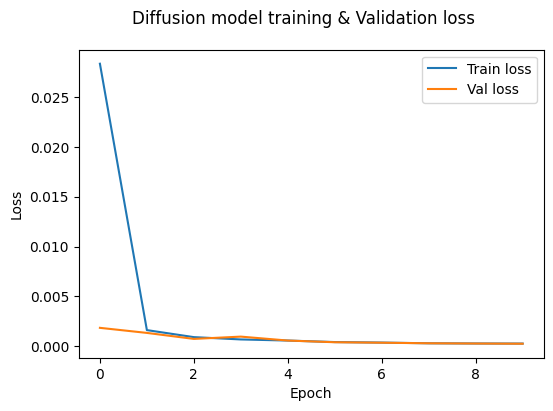

In [27]:
fig, ax = plt.subplots(figsize=(6, 4))
fig.suptitle("Diffusion model training & Validation loss")

ax.plot(train_losses, label="Train loss")
ax.plot(val_losses, label="Val loss")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

plt.show()

In [28]:
# Optionally save the model
torch.save(model.model.state_dict(), "diffusion_unet_with_lr.pth")

#### Testing the diffusion model: Pong image generation

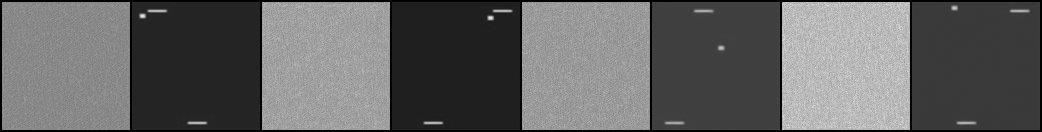

In [30]:
n_images = 8
n_channels = 1
num_inference_steps = 1000

sample = model.generate(n_images, n_channels, num_inference_steps)

show_images(sample)

## - Using VAE to generate latent representations (z)

In [15]:
dataset = load_dataset("DiffusionArcade/Pong", split="train")

split_datasets = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets["train"]
val_dataset   = split_datasets["test"]

Resolving data files:   0%|          | 0/27239 [00:00<?, ?it/s]

#### 1. Testing VAE: encoding Pong frames and decoding them to reconstruct the original images

In [16]:
from src.diffusion.vae import VAE
from src.utils import load_config

config = load_config("../config.yaml")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = config['training_latents']['image_size']
vae_name = config['training_latents']['vae_name']

vae = VAE(vae_name=vae_name, device=device, image_size=image_size)

The VAE was correctly instantiated!


#### 1.1. Encoding Pong images

In [17]:
batch_size = config['training_latents']['batch_size']

train_dataset.set_transform(vae.encode_batch)
val_dataset.set_transform(vae.encode_batch)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [18]:
for batch in train_dataloader:
    print('Encoded images -> latents shape:', batch['latents'].shape)
    break

Encoded images -> latents shape: torch.Size([64, 4, 16, 16])


#### 1.2. Checking noise added by the cosine scheduler

X shape: torch.Size([8, 4, 16, 16])
Batch of latents in training dataset:


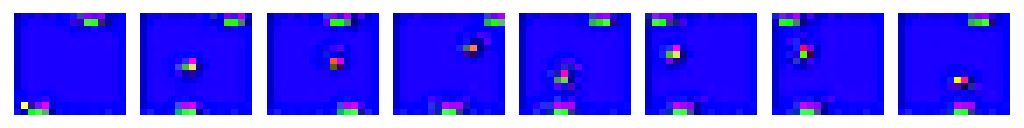

In [19]:
train_batch_latents = next(iter(train_dataloader))["latents"].to(device)[:8]
print("X shape:", train_batch_latents.shape)

print('Batch of latents in training dataset:')
show_images(train_batch_latents).resize((8 * image_size, image_size), resample=Image.NEAREST)

Noisy X shape torch.Size([8, 4, 16, 16])


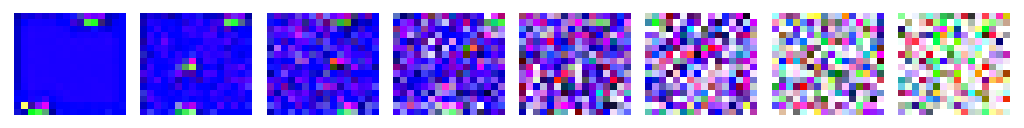

In [23]:
noise = torch.randn_like(train_batch_latents) # same shape as xb: [Batch size, Channels, Height, Width]

timesteps = torch.linspace(0, 999, 8).long().to(device)

noisy_train_batch_latents = schedulers["cosine"].add_noise(train_batch_latents, noise, timesteps)

print("Noisy X shape", noisy_train_batch_latents.shape)
show_images(noisy_train_batch_latents).resize((8 * image_size, image_size), resample=Image.NEAREST)

In [24]:
timesteps

tensor([  0, 142, 285, 428, 570, 713, 856, 999], device='cuda:0')

#### 1.3. Decoding latent representations

Decoded latents batch: torch.Size([8, 3, 128, 128])


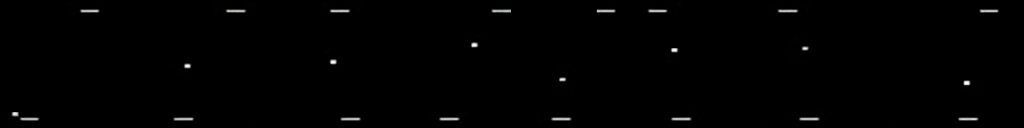

In [26]:
batch = next(iter(train_dataloader))
latents = batch["latents"]               # shape [B, C, h, w]

decoded_tensor = vae.decode_latents(latents)[:8]
print(f"Decoded latents batch:", decoded_tensor.shape)

show_images(decoded_tensor).resize((8 * image_size, image_size), resample=Image.NEAREST)

## - Using VAE latent representations in the diffusion model

In [7]:
from src.diffusion.model import LatentDiffusionModel
from src.diffusion.vae import VAE
from src.utils import login_huggingface, load_config, get_formatted_run_name

config = load_config("../config.yaml")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

login_huggingface()

#### Step 1: Load the VAE

In [8]:
vae_name = config["training_latents"]["vae_name"]
image_size = config['training_latents']['image_size']

vae = VAE(vae_name=vae_name, device=device, image_size=image_size)

The VAE was correctly instantiated!


#### Step 2: Loading the dataset and encoding images to generate latents

In [9]:
print("Loading the dataset...")
batch_size = config["training_latents"]["batch_size"]

dataset = load_dataset("DiffusionArcade/Pong", split="train")

split_datasets = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets["train"]
val_dataset = split_datasets["test"]

print("Encoding images...")
train_dataset.set_transform(vae.encode_batch)
val_dataset.set_transform(vae.encode_batch)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Latent representations generated successfully!")

Loading the dataset...


Resolving data files:   0%|          | 0/27239 [00:00<?, ?it/s]

Encoding images...
Latent representations generated successfully!


In [10]:
for batch in train_dataloader:
    print("Shape of a batch of latent representations:", batch["latents"].shape) # This should be [B, C, H, W]
    break

Shape of a batch of latent representations: torch.Size([64, 4, 16, 16])


#### Step 3: Training the diffusion model with latent representations

In [11]:
latent_channels = vae.latent_channels
latent_size = vae.latent_size
scheduler = config["training_latents"]["scheduler"]

model = LatentDiffusionModel(
    latent_channels=latent_channels,
    latent_size=latent_size,
    noise_scheduler=scheduler
)

In [12]:
epochs = config["training_latents"]["epochs"]

lr = config["training_latents"]["learning_rate"]
wandb_cfg = {
    "project": config["wandb"]["project"],
    "entity": config["wandb"]["entity"],
    "name": get_formatted_run_name(config['wandb']['run_name']),
    "config": config
}

train_losses, val_losses = model.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=epochs,
    lr=lr,
    wandb_config=wandb_cfg,
)

wandb: Currently logged in as: adriana-orellana-torrico to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 341/341 [01:46<00:00,  3.20it/s, loss=0.0474]


Epoch [1/1] Train Loss: 0.0829 Val Loss: 0.04711569012900771 LR: 1.16e-07


epoch,▁
epoch/train_loss,▁
epoch/val_loss,▁
train/loss,█▆▄▃▃▂▂▂▂▂▂▁▂▁▂▂▂▂▂▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch,1
epoch/train_loss,0.08286
epoch/val_loss,0.04712
train/loss,0.04741


In [13]:
model

#### (Optional) Step 4: Save the model

In [16]:
model.save(
    output_dir=config["training_latents"]["output_dir"],
    hf_org=config["training_latents"]["hf_org"],
    model_name=config["training_latents"]["model_name"]
)

Model saved successfully to models/latent_diffusion_unet.pth!
Pushing model to Hugging Face repo: DiffusionArcade/latent_diffusion_unet...


latent_diffusion_unet.pth:   0%|          | 0.00/74.3M [00:00<?, ?B/s]

Model pushed to Hugging Face: https://huggingface.co/DiffusionArcade/latent_diffusion_unet/blob/main/latent_diffusion_unet.pth


In [18]:
# to load the locally saved model, uncomment the following lines

model = LatentDiffusionModel()
model.model.load_state_dict(torch.load("models/latent_diffusion_unet.pth")) # or update to the correct path
model.model.eval()
print('Loaded model!')

Loaded model!


#### Step 5: Evaluate the model

Latent representations shape: torch.Size([8, 4, 16, 16])
Decoded tensor shape: torch.Size([8, 3, 128, 128])


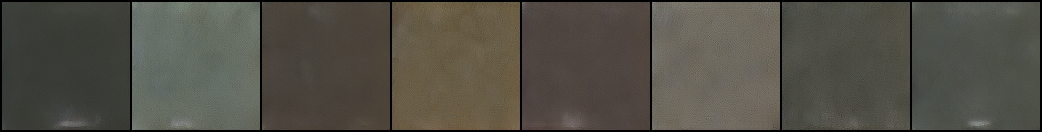

In [20]:
n_images = 8

# num_inference_steps must be 1000 when using the DDPM scheduler. Otherwise, this variable can have different values (DDIM scheduler)
num_inference_steps = 1000

latents = model.generate_latents(n_images, num_inference_steps)
print("Latent representations shape:", latents.shape)

decoded_tensor = vae.decode_latents(latents)
print("Decoded tensor shape:", decoded_tensor.shape)

show_images(decoded_tensor)

### - Adding context to the latent difussion model

## References

1. **Hugging Face Diffusion Course, Unit 0: Introduction to Diffusion Models**  
   Available online: [https://huggingface.co/learn/diffusion-course/en/unit0/1](https://huggingface.co/learn/diffusion-course/en/unit0/1)

2. **Ho, J., Jain, A., & Abbeel, P.** (2020). *Denoising Diffusion Probabilistic Models*.  
   arXiv preprint arXiv:2006.11239. [PDF](https://arxiv.org/pdf/2006.11239)

3. **Rombach, R., Blattmann, A., Lorenz, D., Esser, P., & Ommer, B.** (2022). *High-Resolution Image Synthesis with Latent Diffusion Models*.  
   arXiv preprint arXiv:2208.11970. [PDF](https://arxiv.org/pdf/2208.11970)
